In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import src.utilerias.reader as rd
import src.utilerias.utilerias as utls

# Llamamos a la función antes de ejecutar el script
logs_dir = 'logs/LSTM/estandar'
logs_dir_auto_pred = 'logs/LSTM/auto_predictiva'
utls.eliminar_archivos_registro(logs_dir)
utls.eliminar_archivos_registro(logs_dir_auto_pred)

In [2]:
# DATOS = 'cierre.csv'#Grupo Financiero Inbursa
# DATOS = 'Datos históricos COMI 03012016_27122020.csv' #Datos originales
# DATOS = 'datos/Datos históricos COMI 3ene16-31dic2020 semanal.csv' #Datos semanales
# DATOS = 'Datos históricos COMI_prueba 30jun19-31dic2020.csv' #Datos semanales de prueba
# DATOS = 'Datos históricos COMI3ene2016_27dic2020_diario.csv' #Datos originales diarios de prueba
# DATOS = 'Datos históricos COMI_prueba 30jun19-31dic2020_DIARIO.csv' #Datos diarios de prueba

DATOS = 'datos\_nacionales\entidades financieras\ACTINVRB\_030116_ 311223.csv'

cierre = rd.leer_archivo(DATOS).astype(float)

#Obtenemos el conjunto de entrenamiento
c_entrenamiento = np.array(cierre[:int(len(cierre) * 0.7)])

#Muestreo aleatorio
# # Genera índices aleatorios únicos y ordenados
# indices_aleatorios = np.sort(np.random.choice(len(cierre), size=int(0.3 * len(cierre)) + 8, replace=False))
# # Selecciona los elementos correspondientes a los índices ordenados
# c_prueba = cierre[indices_aleatorios]
# # Calcula los índices del 70% restante (complemento del conjunto del 30%)
# indices_restantes = np.setdiff1d(np.arange(len(cierre)), indices_aleatorios)
# # Selecciona los elementos correspondientes a los índices restantes
# c_entrenamiento = cierre[indices_restantes]

#Se convierte en un arreglo bidimensional
c_entrenamiento = np.reshape(c_entrenamiento, (c_entrenamiento.shape[0], 1))

In [3]:
from sklearn.preprocessing import MinMaxScaler

# Se normalizan los datos en un rango de 0 a 1
m_m_s = MinMaxScaler(feature_range=(0,1))
c_entrenamiento_n = m_m_s.fit_transform(c_entrenamiento)

In [4]:
#Se crean los conjuntos de entradas y salidas para la red, que funcionaran para predecir y comparar con las salidas esperadas a la hora de realizar el entrenamiento
time_steps = 8 # la cantidad de semanas anteriores a partir de las cuales se va a predecir la novena semana
N = len(c_entrenamiento_n) #182
X_entrenamiento_n = []
y_entrenamiento_n = []
for i in range(time_steps, N):
    X_entrenamiento_n.append(c_entrenamiento_n[i-time_steps:i, 0])#toma paquetes de 8 en 8
    y_entrenamiento_n.append(c_entrenamiento_n[i, 0])#se toma el elemento 8+1
X_entrenamiento_n, y_entrenamiento_n = np.array(X_entrenamiento_n), np.array(y_entrenamiento_n)

#Se le da una tercera dimension al conjunto de entradas de entrenamiento
X_entrenamiento_n = np.reshape(X_entrenamiento_n, (X_entrenamiento_n.shape[0], X_entrenamiento_n.shape[1], 1))

In [5]:
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.losses import mean_squared_error
from keras.models import load_model


In [6]:
from src.modelos.recurrente.LSTM.LSTM import red_LSTM
from src.modelos.recurrente.GRU.GRU import red_GRU
from src.modelos.auto_regresivo.NARNN_keras.NARNN import NARNN
from keras.callbacks import TensorBoard
import src.modelos.recurrente.entrenamientos.entrenamiento as entr

red = red_LSTM(input_dim = X_entrenamiento_n.shape[1],output_dim= 1)
red(np.ones((1, 8, 1)))  # el modelo es instanciado y llamado por primera vez
red.load_weights('redes/LSTM/estandar/ACTINVRB/red_LSTM_lr0-0001_e60_batch32.h5')

# red.compile(optimizer=Adam(learning_rate=0.0001),loss='mean_squared_error')# se compila la red # mejor, , SGD(learning_rate=0.1)
# history = red.fit(X_entrenamiento_n,y_entrenamiento_n,epochs=60,batch_size=32,
#                   callbacks=[entr.CalendarizadorPesos(logs_dir + f'/red_LSTM'), 
#                                    entr.CalendarizadorPredicciones(logs_dir + f'/red_LSTM', X_entrenamiento_n, y_entrenamiento_n),
#                                    TensorBoard(log_dir=logs_dir + f'/red_LSTM', histogram_freq=1)])
# # Guardar el modelo entrenado
# red.save_weights('redes/LSTM/estandar/ACTINVRB/red_LSTM_lr0-0001_e60_batch32.h5')


In [7]:
precios_reales = cierre[int(len(cierre) * 0.7):] #verdaderos valores del conjunto de prueba
precios_reales = np.reshape(precios_reales, (precios_reales.shape[0], 1)) #se le da una dimension mas

# Muestreo aleatorio
# precios_reales = c_prueba[8:]

In [8]:
# Se crea el conjunto de prueba
#toma los ultimos 86 elementos, los ultimos 8 de entrenamiento y todos los de prueba 
# Comentar para Muestreo aleatorio 
c_prueba = cierre[len(cierre) - len(precios_reales) - time_steps:]

c_prueba = np.array(c_prueba).reshape(-1,1) #(86,1)

# se normalizan los datos usandlo los parametros que se le dieron a m_m_s
m_m_s_prueba = MinMaxScaler(feature_range=(0,1))
c_prueba_n = m_m_s_prueba.fit_transform(c_prueba)

X_prueba_n = []
for i in range(time_steps, len(c_prueba_n)):
    X_prueba_n.append(c_prueba_n[i-time_steps:i, 0]) # se toman en paquetes de 8 
X_prueba_n = np.array(X_prueba_n)
X_prueba_n = np.reshape(X_prueba_n, (X_prueba_n.shape[0], X_prueba_n.shape[1], 1))#(78, 8, 1)

precios_predichos = red.predict(X_prueba_n)

#Se desnormalizan los datos
precios_predichos = m_m_s_prueba.inverse_transform(precios_predichos)

4/4 [==============================] - 1s 7ms/step


# Predicción del conjunto de prueba

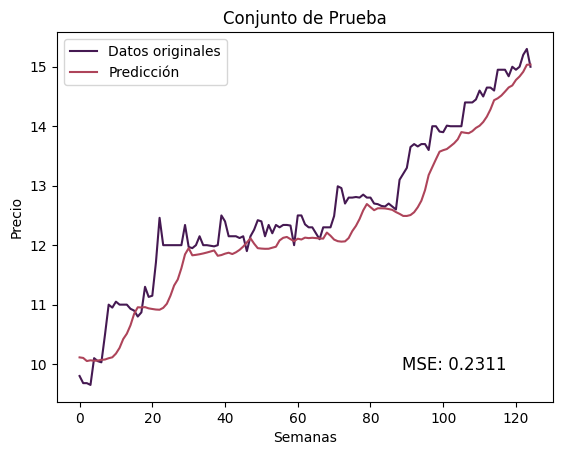

Perdida: 0.2311128145161756


In [9]:
plt.plot(precios_reales, color = '#451952', label = 'Datos originales')
plt.plot(precios_predichos, color='#AE445A', label = 'Predicción')
plt.title('Conjunto de Prueba')
plt.xlabel('Semanas')
plt.ylabel('Precio')
mse_e = mean_squared_error(np.reshape(precios_predichos, (precios_predichos.shape[0])), np.reshape(precios_reales, (precios_reales.shape[0])))
plt.text(0.8, 0.1, f"MSE: {round(float(mse_e),4)}", fontsize=12, ha='center', va='center', transform=plt.gca().transAxes)

plt.legend()
plt.show()
print(f"Perdida: {mean_squared_error(np.reshape(precios_predichos, (precios_predichos.shape[0])), np.reshape(precios_reales, (precios_reales.shape[0])))}")

# Evaluación de desempeño

In [10]:
import pandas as pd
r_c_prueba_txt = 'Precicción de c_prueba'
# Supongamos que tenemos una lista de errores de predicción para cada red neuronal
rmse = {
    r_c_prueba_txt: utls.rmse(precios_reales,precios_predichos)
}
mape = {
    r_c_prueba_txt: utls.mape(precios_reales,precios_predichos)
}
ds = {
    r_c_prueba_txt: utls.directional_symmetry(precios_reales,precios_predichos)
}

# Creamos un DataFrame de Pandas a partir del diccionario de errores
df_errores = pd.DataFrame({
    'RMSE': pd.Series(rmse),
    'MAPE': pd.Series(mape),
    'DS': pd.Series(ds)
})

# Mostramos el DataFrame con los errores
print(df_errores) 

                          RMSE      MAPE    DS
Precicción de c_prueba  0.4807  3.023597  58.4


# Generamos el entrenamiento predictivo

In [11]:
# Definimos el número de epocas

#epocas/lr para entrenamiento optimo sin implementación de decay_factor
#EPOCAS = 60
#LR = 0.00003

EPOCAS = 100
LR = 0.0001
BS = 8
DF=0.1

In [12]:
#red.load_weights('redes/LSTM/auto_predictiva/ACTINVRB/red_LSTM_lr0-00003_e60_df0.h5')
#red.load_weights('redes/LSTM/auto_predictiva/ACTINVRB/red_LSTM_lr0.0001_e100_bs8_df0.1.h5')

# str_conj_datos = 'ACTINVRB'

# import src.modelos.recurrente.entrenamientos.entrenamiento as entrena_lstm
# entrena_lstm.entrena(red,c_entrenamiento_n,y_entrenamiento_n,8,epocas= EPOCAS, lr=LR, t_lote = BS,
#                      callbacks=[entr.CalendarizadorTasaAprendizaje(log_dir=logs_dir_auto_pred+ f'/red_LSTM',initial_lr=LR, decay_factor=DF,red = red),
#                                         entr.CalendarizadorPesos(log_dir=logs_dir_auto_pred+ f'/red_LSTM',e_predictivo=True,genera_histogramas=True,red = red)],
#                                         log_dir=logs_dir_auto_pred+ f'/red_LSTM', optimizador=Adam)

# # red.save_weights(f'redes/LSTM/auto_predictiva/LSTM.h5')
# red.save_weights(f'redes/LSTM/auto_predictiva/{str_conj_datos}/red_LSTM_lr{LR}_e{EPOCAS}_bs{BS}_df{DF}.h5')

In [13]:
# Predice el conjunto de entrenamiento usando la prediccion predictiva a partir de los primeros (usando los datos que predice)
red_ap_precios_predichos_n = utls.genera_pred_auto_predictiva(c_entrenamiento_n.reshape(c_entrenamiento_n.shape[0]),time_steps,red)  
# le quitamos 8 al tamaño de datos pues 
#al principio de la funcion "genera_prediccion_predictiva" concatena los primeros 8 elementos

1/1 [==============================] - 0s 20ms/step


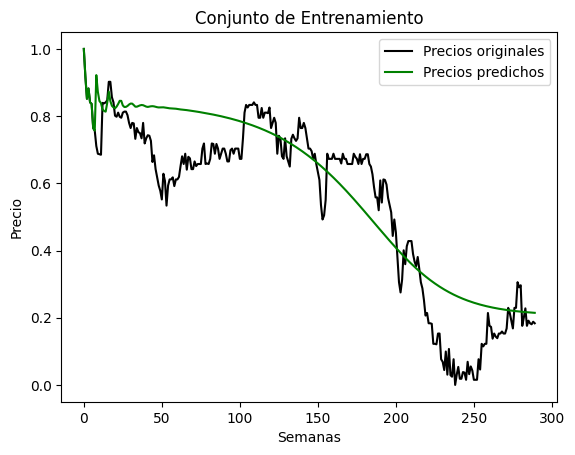

Perdida: 0.014360175042547661


In [14]:
plt.plot(c_entrenamiento_n, color = 'black', label = 'Precios originales')
plt.plot(red_ap_precios_predichos_n, color = 'green', label = 'Precios predichos')
plt.title('Conjunto de Entrenamiento')
plt.xlabel('Semanas')
plt.ylabel('Precio')
plt.legend()
plt.show()
print(f"Perdida: {mean_squared_error(np.reshape(red_ap_precios_predichos_n, (red_ap_precios_predichos_n.shape[0])), np.reshape(c_entrenamiento_n, (c_entrenamiento_n.shape[0])))}")

In [15]:
# Ahora, el modelo ha sido entrenado de manera iterativa
# Predice el conjunto de prueba usando la prediccion predictiva (ñps datos que va prediciendo)
red_ap_precios_predichos = utls.genera_pred_auto_predictiva(c_prueba_n.reshape(c_prueba_n.shape[0]),time_steps,red)
temp = red_ap_precios_predichos
red_ap_precios_predichos = m_m_s_prueba.inverse_transform(red_ap_precios_predichos.reshape(c_prueba.shape[0],1))

#le quitamos los primeros 8 elementos pues hacen parte del conjunto de entrenamiento, para que salga más limpio
# el analisis
red_ap_precios_predichos = red_ap_precios_predichos[time_steps:]

1/1 [==============================] - 0s 16ms/step


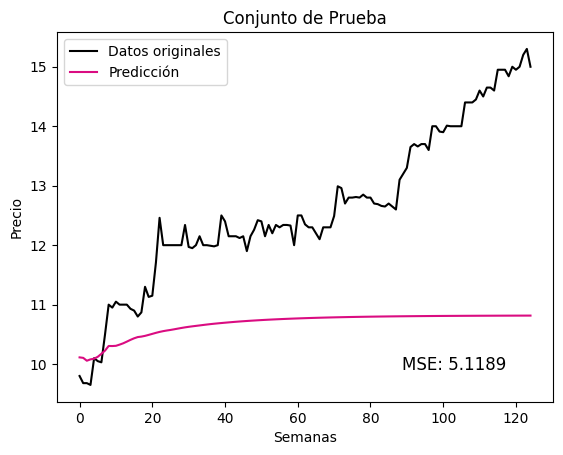

In [16]:
#Sin normalizar
#red_ap_precios_predichos = m_m_s_prueba.inverse_transform(c_prueba_n)
plt.plot(precios_reales, color = 'black', label = 'Datos originales') #c_prueba_n
plt.plot(red_ap_precios_predichos, color='#DA0C81', label = 'Predicción')
plt.title('Conjunto de Prueba')
plt.xlabel('Semanas')
plt.ylabel('Precio')
mse_e = mean_squared_error(np.reshape(red_ap_precios_predichos, (red_ap_precios_predichos.shape[0])), np.reshape(precios_reales, (precios_reales.shape[0])))
plt.text(0.8, 0.1, f"MSE: {round(float(mse_e),4)}", fontsize=12, ha='center', va='center', transform=plt.gca().transAxes)
plt.legend()
plt.show()

In [17]:
import pandas as pd
r_c_prueba_txt = 'Precicción de c_prueba'
# Supongamos que tenemos una lista de errores de predicción para cada red neuronal
rmse = {
    r_c_prueba_txt: utls.rmse(precios_reales, red_ap_precios_predichos)
}
mape = {
    r_c_prueba_txt: utls.mape(precios_reales, red_ap_precios_predichos)
}
ds = {
    r_c_prueba_txt: utls.directional_symmetry(precios_reales, red_ap_precios_predichos)
}

# Creamos un DataFrame de Pandas a partir del diccionario de errores
df_errores = pd.DataFrame({
    'RMSE': pd.Series(rmse),
    'MAPE': pd.Series(mape),
    'DS': pd.Series(ds)
})

# Mostramos el DataFrame con los errores
print(df_errores) 

                          RMSE       MAPE    DS
Precicción de c_prueba  2.2625  14.845069  60.8


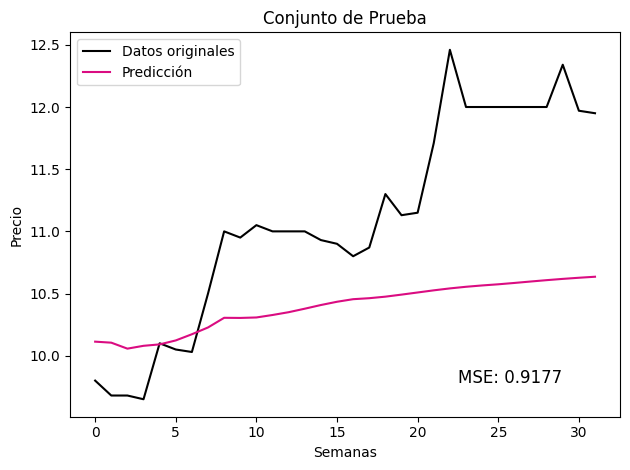

                         RMSE     MAPE    DS
Precicción de c_prueba  0.958  7.02598  62.5


In [18]:
cota_semanas = 32

plt.plot(precios_reales[: cota_semanas], color = 'black', label = 'Datos originales') #c_prueba_n
plt.plot(red_ap_precios_predichos[:cota_semanas], color='#DA0C81', label = 'Predicción')
plt.title('Conjunto de Prueba')
plt.xlabel('Semanas')
plt.ylabel('Precio')
mse_e = mean_squared_error(np.reshape(red_ap_precios_predichos[:cota_semanas], (red_ap_precios_predichos[:cota_semanas].shape[0])), np.reshape(precios_reales[: cota_semanas], (precios_reales[: cota_semanas].shape[0])))
plt.text(0.8, 0.1, f"MSE: {round(float(mse_e),4)}", fontsize=12, ha='center', va='center', transform=plt.gca().transAxes)
plt.legend()

plt.tight_layout()
plt.show()

rmse = {
    r_c_prueba_txt: utls.rmse(precios_reales[:cota_semanas],red_ap_precios_predichos[:cota_semanas])
}
mape = {
    r_c_prueba_txt: utls.mape(precios_reales[:cota_semanas],red_ap_precios_predichos[:cota_semanas])
}
ds = {
    r_c_prueba_txt: utls.directional_symmetry(precios_reales[:cota_semanas],red_ap_precios_predichos[:cota_semanas])
}

# Creamos un DataFrame de Pandas a partir del diccionario de errores
df_errores = pd.DataFrame({
    'RMSE': pd.Series(rmse),
    'MAPE': pd.Series(mape),
    'DS': pd.Series(ds)
})

# Mostramos el DataFrame con los errores
print(df_errores) 

In [19]:
# Ahora, el modelo ha sido entrenado de manera iterativa
# Predice el conjunto de prueba usando la prediccion predictiva (ñps datos que va prediciendo)
red_ap_precios_predichos = utls.genera_pred_auto_predictiva(c_prueba_n.reshape(c_prueba_n.shape[0]),time_steps,red,correccion=True)
temp = red_ap_precios_predichos
red_ap_precios_predichos = m_m_s_prueba.inverse_transform(red_ap_precios_predichos.reshape(c_prueba.shape[0],1))

#le quitamos los primeros 8 elementos pues hacen parte del conjunto de entrenamiento, para que salga más limpio
# el analisis
red_ap_precios_predichos = red_ap_precios_predichos[time_steps:]

1/1 [==============================] - 0s 16ms/step


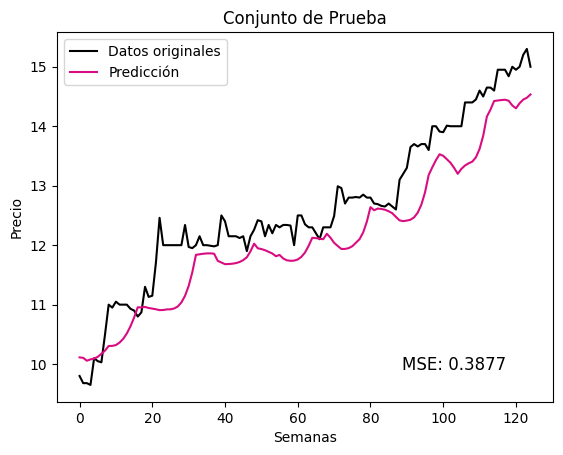

In [20]:
#Sin normalizar
#red_ap_precios_predichos = m_m_s_prueba.inverse_transform(c_prueba_n)
plt.plot(precios_reales, color = 'black', label = 'Datos originales') #c_prueba_n
plt.plot(red_ap_precios_predichos, color='#DA0C81', label = 'Predicción')
plt.title('Conjunto de Prueba')
plt.xlabel('Semanas')
plt.ylabel('Precio')
mse_e = mean_squared_error(np.reshape(red_ap_precios_predichos, (red_ap_precios_predichos.shape[0])), np.reshape(precios_reales, (precios_reales.shape[0])))
plt.text(0.8, 0.1, f"MSE: {round(float(mse_e),4)}", fontsize=12, ha='center', va='center', transform=plt.gca().transAxes)
plt.legend()
plt.show()

rmse = {
    r_c_prueba_txt: utls.rmse(precios_reales, red_ap_precios_predichos)
}
mape = {
    r_c_prueba_txt: utls.mape(precios_reales, red_ap_precios_predichos)
}
ds = {
    r_c_prueba_txt: utls.directional_symmetry(precios_reales, red_ap_precios_predichos)
}

# Creamos un DataFrame de Pandas a partir del diccionario de errores
df_errores = pd.DataFrame({
    'RMSE': pd.Series(rmse),
    'MAPE': pd.Series(mape),
    'DS': pd.Series(ds)
})

# Mostramos el DataFrame con los errores
print(df_errores) 